## Creditcard-Fraud: imbalanced data

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, f1_score, accuracy_score,\
                            roc_auc_score, average_precision_score, precision_recall_curve, auc,\
                            roc_curve, precision_score, recall_score

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from copy import copy
from numpy import random

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'png'

In [2]:
# https://www.kaggle.com/mlg-ulb/creditcardfraud
df = pd.read_csv("../data/creditcard.csv")
df.shape

(284807, 31)

### the data-set is too large - we subsample the majority class

In [3]:
no_fraud = df.index[df['Class']==0]
fraud = df.index[df['Class']==1].tolist()
sampled = random.choice(no_fraud, size=100000, replace=False).tolist()
df = df.loc[fraud + sampled, ].reset_index()
df.to_csv("../data/creditcard_subsampled.csv", header=True, index=False)

In [4]:
print(f"num anomalies {np.sum(df['Class']==1)}/{len(df)} = {100*np.sum(df['Class']==1)/len(df):.2f}%")

num anomalies 492/100492 = 0.49%


## what will our accuracy be ad hoc?

In [5]:
pd.crosstab(df.Class.astype(str) + "_true", pd.Series(np.zeros_like(df.Class)).astype(str) + "_Actual")

col_0,0_Actual
Class,
0_true,100000
1_true,492


 - $\text{accuracy} = \frac{\text{true positives + true negatives}}{\text{true negatives + false negatives + true positives + false positives}} = \frac{0 + 284315}{492 + 284315} = 0.998$

## get a model

In [6]:
import lightgbm
model = lightgbm.LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=- 1, learning_rate=0.1, 
                                n_estimators=500, subsample_for_bin=20000, objective='binary', 
                                subsample=1.0, subsample_freq=0, colsample_bytree=1.0, 
                                n_jobs=- 1, silent=True, importance_type='split',
                                is_unbalance = False, scale_pos_weight = 1.0)


## train / test split

In [16]:
X, y = df.drop('Class', axis=1), df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
clf = copy(model)
clf.fit(X_train,y_train)



LGBMClassifier(is_unbalance=False, n_estimators=500, objective='binary',
               scale_pos_weight=1.0, subsample_for_bin=20000)

In [17]:
display(sum(y_train), sum(y_test))

381

111

In [18]:
(clf.predict_proba(X_test.iloc[3:4,:]) + clf.predict_proba(X_test.iloc[3:4,:]))/2

array([[9.99999999e-01, 7.46990502e-10]])

In [19]:
y_pred = clf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
y_pred_proba = clf.predict_proba(X_test)[:,1] # 2nd column is p(fraud)
AUC = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, pos_label=1)
PR = auc(recall, precision)
FPR, TPR, _ = roc_curve(y_test, y_pred_proba)
df_conf = pd.DataFrame(confusion, columns=['non-Fraud','Fraud'], index=['non-Fraud','Fraud'])
df_conf

,non-Fraud,Fraud
non-Fraud,19982,6
Fraud,24,87


sensitivity, recall, hit rate, or true positive rate (TPR)

 
 \begin{equation}
 \text{Precision}=\frac{\text{TP}}{\text{TP + FP}}
   \end{equation}
  
  \begin{equation} 
 \text{Recall}=\text{Sensitivity}=\text{TPR}=\frac{\text{TP}}{\text{P}} =\frac{\text{TP}}{\text{TP + FN}}
    \end{equation}
    
   \begin{equation} 
 \text{F}_1\text{-Score} = 2\frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
     \end{equation}
     
   \begin{equation}   
  \text{FPR}=\frac{\text{FP}}{\text{N}} =\frac{\text{FP}}{\text{FP + TN}}
    \end{equation} 
    
The normal ROC auc is computed for the True Positive Rate (TPR) and the False Positive Rate (FPR)    

In [28]:
print(f"Precision {precision_score(y_test, y_pred):.3f}, Recall {recall_score(y_test, y_pred):.3f}")
print(f"F1 {f1_score(y_test, y_pred):.2f}, Accuracy {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC {AUC:.2f}, AUC PR {PR:.2f}")

Precision 0.935, Recall 0.784
F1 0.85, Accuracy 0.9985
ROC AUC 0.96, AUC PR 0.85


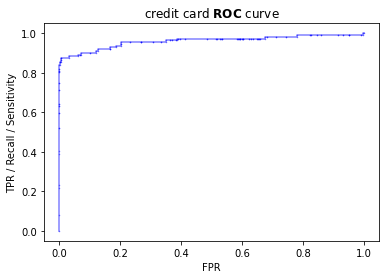

In [29]:
plt.plot(FPR, TPR, 'b.-', markersize=1, alpha=0.5)
plt.xlabel("FPR")
plt.ylabel("TPR / Recall / Sensitivity")
plt.title(f"credit card $\\bf ROC$ curve")
plt.savefig("/tmp/ROC-curve.png", dpi=200)
plt.show()

Because of the imbalance, the FPR has from the beginning on very low values. For imbalanced data, th ROC AUC of this curve is not ideal to compare different algorithms:<br>
Suppose there are 100 positive cases in the data and 100'000 negative cases:<br>

\begin{eqnarray}
\text{algorithm 1: 2000 false positives:  FPR } =\frac{\text{FP}}{\text{FP + TN}} = &\frac{2000}{2000 + 100000} = 0.0196\\
\text{algorithm 2:   200  false positives:  FPR } =\frac{\text{FP}}{\text{FP + TN}} = &\;\;\frac{200}{200+ 100000} \;=\; 0.001966
\end{eqnarray}

(array([2.0005e+04, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00, 8.8000e+01]),
 array([2.02882051e-23, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

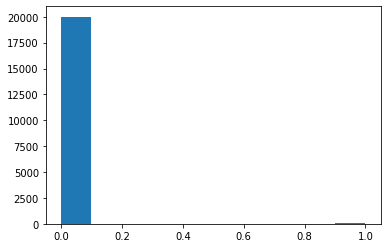

In [30]:
plt.hist(y_pred_proba)

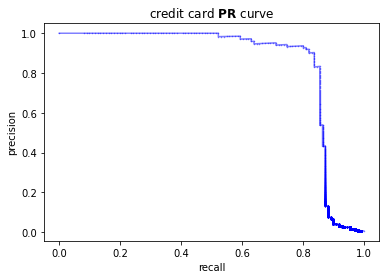

In [31]:
plt.plot(recall, precision, 'b.-', markersize=1, alpha=0.5)
plt.xlabel("recall")
plt.ylabel("precision")
plt.title(f"credit card $\\bf PR$ curve")
plt.savefig("/tmp/PR-curve.png", dpi=200)
plt.show()

For imbalanced data, precision is the better measure:
Suppose there are 100 positive cases in the data and 100'000 negative cases:<br>
Both algorithms classifiy 50 cases correctly:<br>

\begin{eqnarray}
\text{algorithm 1: 2000 false positives:  }\; \text{Precision}=\frac{\text{TP}}{\text{TP + FP}} = &\frac{50}{50 + 2000} = 0.0243\\
\text{algorithm 2:   200  false positives:  }\; \text{Precision}=\frac{\text{TP}}{\text{TP + FP}} = &\;\;\frac{50}{50 + 200} \;=\; 0.2
\end{eqnarray}

In [34]:
# keep the workspace tidy
y_pred, confusion, y_pred_proba, precision, recall = None, None, None, None, None
del y_pred, confusion, y_pred_proba, precision, recall

## proper test set?

In [35]:
# must split out test set first but get 20% from each class at original ratio of fraud/good
df_good = df[df['Class']==0]
df_fraud = df[df['Class']==1]

df_train_good, df_test_good   = train_test_split(df_good, test_size=0.20)
df_train_fraud, df_test_fraud = train_test_split(df_fraud, test_size=0.20)

df_train = pd.concat([df_train_good, df_train_fraud], axis=0)
df_test  = pd.concat([df_test_good, df_test_fraud], axis=0)

print(f"TRAIN num fraud {np.sum(df_train['Class']==1)}/{len(df_train)} = {100*np.sum(df_train['Class']==1)/len(df_train):.2f}%")
print(f"TEST num fraud {np.sum(df_test['Class']==1)}/{len(df_test)} = {100*np.sum(df_test['Class']==1)/len(df_test):.2f}%")

TRAIN num fraud 393/80393 = 0.49%
TEST num fraud 99/20099 = 0.49%


In [36]:
# keep the workspace tidy
df_good, df_fraud, df_train_good, df_test_good, df_train_fraud, df_test_fraud, df_train, df_test =None,None,None,None, None, None, None,None
del df_good, df_fraud, df_train_good, df_test_good, df_train_fraud, df_test_fraud, df_train, df_test

we can also do this with a sklearn data-set splitter:

In [37]:
from sklearn.model_selection import StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits=2, test_size=0.2, train_size=0.8)
idx = next(splitter.split(df, df.Class))
train_idx = idx[0]
test_idx = idx[1]

In [38]:
len(test_idx)

20099

In [39]:
df_train = df.loc[train_idx]
df_test = df.loc[test_idx]
print(f"TRAIN num fraud {np.sum(df_train['Class']==1)}/{len(df_train)} = {100*np.sum(df_train['Class']==1)/len(df_train):.2f}%")
print(f"TEST num fraud {np.sum(df_test['Class']==1)}/{len(df_test)} = {100*np.sum(df_test['Class']==1)/len(df_test):.2f}%")

TRAIN num fraud 394/80393 = 0.49%
TEST num fraud 98/20099 = 0.49%


In [40]:
X_train, y_train = df_train.drop('Class', axis=1), df_train['Class']
X_test, y_test = df_test.drop('Class', axis=1), df_test['Class']
clf = copy(model)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
df_conf = pd.DataFrame(confusion, columns=['F','T'], index=['F','T'])
df_conf

,F,T
F,19949,52
T,69,29


In [41]:
y_pred_proba = clf.predict_proba(X_test)[:,1] # 2nd column is p(fraud)
AUC = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, pos_label=1)
PR = auc(recall, precision)
print(f"Precision {precision_score(y_test, y_pred):.3f}, Recall {recall_score(y_test, y_pred):.3f}")
print(f"F1 {f1_score(y_test, y_pred):.2f}, Accuracy {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC {AUC:.2f}, AUC PR {PR:.2f}")

Precision 0.358, Recall 0.296
F1 0.32, Accuracy 0.9940
ROC AUC 0.65, AUC PR 0.32


In [42]:
# keep workspace tidy
df, idx, df_train, df_test, clf, precision, recall, y_pred, y_pred_proba = None, None, None, None, None, None, None, None,None
del df, idx, df_train, df_test, clf, precision, recall, y_pred, y_pred_proba

# Strategies for the imbalanced case:
 - oversample the minority class
 - undersample the majority class
 - do both of the former two suggestions
 - oversample only the cases that get missclassified
 - set `is_unbalance` and/or `scale_pos_weight` parameters in lightgbm

## oversample fraud

### Synthetic Minority Oversampling Technique = SMOTE
The [original paper is here](https://arxiv.org/abs/1106.1813)<br>
The idea is to connect very close points in the feature space and generate new samples lying on the connecting line. This is done for the minority class only.

In [43]:
import imblearn
from imblearn.over_sampling import SMOTE, ADASYN
X_train_ov, y_train_ov = SMOTE(sampling_strategy=0.1).fit_resample(X_train, y_train)

In [44]:
clf = copy(model)
clf.fit(X_train_ov,y_train_ov)
y_pred = clf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
df_conf = pd.DataFrame(confusion, columns=['F','T'], index=['F','T'])
df_conf

,F,T
F,19995,6
T,17,81


In [52]:
y_pred_proba = clf.predict_proba(X_test)[:,1] # 2nd column is p(fraud)
AUC = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, pos_label=1)
PR = auc(recall, precision)
print(f"Precision {precision_score(y_test, y_pred):.3f}, Recall {recall_score(y_test, y_pred):.3f}")
print(f"F1 {f1_score(y_test, y_pred):.2f}, Accuracy {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC {AUC:.2f}, AUC PR {PR:.2f}")

Precision 0.921, Recall 0.837
F1 0.88, Accuracy 0.9989
ROC AUC 0.97, AUC PR 0.86


In [46]:
X_train_ov, y_train_ov, y_pred, y_pred_proba, precision, recall, clf = None, None, None, None, None, None, None
del X_train_ov, y_train_ov, y_pred, y_pred_proba, precision, recall, clf

### Adaptive Synthetic Sampling = ADASYN
The [paper can be found here](https://www.ele.uri.edu/faculty/he/PDFfiles/adasyn.pdf).<br>
More synthetic observations are generated in areas where the density of the minority class is very low. Those cases are hard to learn and upsampling them with SMOTE should make it easier to learn.

In [48]:
# needs too much RAM: 
X_train_ov, y_train_ov = ADASYN(sampling_strategy=0.05).fit_resample(X_train, y_train)

In [49]:
clf = copy(model)
clf.fit(X_train_ov,y_train_ov)
y_pred = clf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
df_conf = pd.DataFrame(confusion, columns=['F','T'], index=['F','T'])
df_conf

,F,T
F,19994,7
T,16,82


In [50]:
y_pred_proba = clf.predict_proba(X_test)[:,1] # 2nd column is p(fraud)
AUC = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, pos_label=1)
PR = auc(recall, precision)
print(f"Precision {precision_score(y_test, y_pred):.3f}, Recall {recall_score(y_test, y_pred):.3f}")
print(f"F1 {f1_score(y_test, y_pred):.2f}, Accuracy {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC {AUC:.2f}, AUC PR {PR:.2f}")

Precision 0.921, Recall 0.837
F1 0.88, Accuracy 0.9989
ROC AUC 0.97, AUC PR 0.86


In [53]:
X_train_ov, y_train_ov, y_pred, y_pred_proba, precision, recall, clf = None, None, None, None, None, None, None
del X_train_ov, y_train_ov, y_pred, y_pred_proba, precision, recall, clf

### Borderline-SMOTE
The [paper can be found here](https://sci2s.ugr.es/keel/keel-dataset/pdfs/2005-Han-LNCS.pdf)<br>
The principal idea is to upsample only those observations that are not classified correctly. The missclassified instances are found by k-nearest-neighbors.

In [54]:
# needs to much RAM for me:
from imblearn.over_sampling import BorderlineSMOTE
X_train_ov, y_train_ov = BorderlineSMOTE(sampling_strategy=0.1).fit_resample(X_train, y_train)

In [55]:
clf = copy(model)
clf.fit(X_train_ov,y_train_ov)
y_pred = clf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
df_conf = pd.DataFrame(confusion, columns=['F','T'], index=['F','T'])
df_conf

,F,T
F,19995,6
T,16,82


In [57]:
y_pred_proba = clf.predict_proba(X_test)[:,1] # 2nd column is p(fraud)
AUC = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, pos_label=1)
PR = auc(recall, precision)
print(f"Precision {precision_score(y_test, y_pred):.3f}, Recall {recall_score(y_test, y_pred):.3f}")
print(f"F1 {f1_score(y_test, y_pred):.2f}, Accuracy {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC {AUC:.2f}, AUC PR {PR:.2f}")

Precision 0.932, Recall 0.837
F1 0.88, Accuracy 0.9989
ROC AUC 0.97, AUC PR 0.84


In [58]:
X_train_ov, y_train_ov, y_pred, y_pred_proba, precision, recall, clf = None, None, None, None, None, None, None
del X_train_ov, y_train_ov, y_pred, y_pred_proba, precision, recall, clf

### Support-Vector-Machine-SMOTE = SVMSMOTE
The class-boundaries for the Borderline are learned as the support-vectors of a Support-Vector-Machine.

In [59]:
from imblearn.over_sampling import SVMSMOTE
X_train_ov, y_train_ov = SVMSMOTE(sampling_strategy=0.1).fit_resample(X_train, y_train)

In [60]:
clf = copy(model)
clf.fit(X_train_ov,y_train_ov)
y_pred = clf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
df_conf = pd.DataFrame(confusion, columns=['F','T'], index=['F','T'])
df_conf

,F,T
F,19994,7
T,16,82


In [61]:
y_pred_proba = clf.predict_proba(X_test)[:,1] # 2nd column is p(fraud)
AUC = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, pos_label=1)
PR = auc(recall, precision)
print(f"Precision {precision_score(y_test, y_pred):.3f}, Recall {recall_score(y_test, y_pred):.3f}")
print(f"F1 {f1_score(y_test, y_pred):.2f}, Accuracy {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC {AUC:.2f}, AUC PR {PR:.2f}")

Precision 0.921, Recall 0.837
F1 0.88, Accuracy 0.9989
ROC 0.97, AUC PR 0.86


In [ ]:
# keep the workspace tidy
X_train_ov, y_train_ovm, y_pred, clf = None, None, None, None
del X_train_ov, y_train_ovm, y_pred, clf

## weigh minority class

In [ ]:
clf = copy(model)
clf.set_params(is_unbalance = True)
#, scale_pos_weight

In [ ]:
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
df_conf = pd.DataFrame(confusion, columns=['F','T'], index=['F','T'])
df_conf

In [ ]:
y_pred_proba = clf.predict_proba(X_test)[:,1] # 2nd column is p(fraud)
AUC = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, pos_label=1)
PR = auc(recall, precision)
print(f"Precision {precision_score(y_test, y_pred):.3f}, Recall {recall_score(y_test, y_pred):.3f}")
print(f"F1 {f1_score(y_test, y_pred):.2f}, Accuracy {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC {AUC:.2f}, AUC PR {PR:.2f}")

In [ ]:
clf.set_params(is_unbalance=False, scale_pos_weight=200.0)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
df_conf = pd.DataFrame(confusion, columns=['F','T'], index=['F','T'])
df_conf

In [ ]:
y_pred_proba = clf.predict_proba(X_test)[:,1] # 2nd column is p(fraud)
AUC = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, pos_label=1)
PR = auc(recall, precision)
print(f"Precision {precision_score(y_test, y_pred):.3f}, Recall {recall_score(y_test, y_pred):.3f}")
print(f"F1 {f1_score(y_test, y_pred):.2f}, Accuracy {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC {AUC:.2f}, AUC PR {PR:.2f}")

In [ ]:
# house-keeping
y_pred_proba, precision, recall, clf, y_pred = None, None, None, None, None
del y_pred_proba, precision, recall, clf, y_pred

## Undersample Fraud

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
X_train_u, y_train_u = RandomUnderSampler(sampling_strategy=0.5).fit_resample(X_train, y_train)
print(X_train.shape, X_train_u.shape)

In [ ]:
clf = copy(model)
clf.fit(X_train_u,y_train_u)
y_pred = clf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
df_conf = pd.DataFrame(confusion, columns=['F','T'], index=['F','T'])
df_conf

In [ ]:
y_pred_proba = clf.predict_proba(X_test)[:,1] # 2nd column is p(fraud)
AUC = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, pos_label=1)
PR = auc(recall, precision)
print(f"Precision {precision_score(y_test, y_pred):.3f}, Recall {recall_score(y_test, y_pred):.3f}")
print(f"F1 {f1_score(y_test, y_pred):.2f}, Accuracy {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC {AUC:.2f}, AUC PR {PR:.2f}")

In [ ]:
y_pred_proba, y_pred, precision, recall, clf, X_train_u, y_train_u = None, None, None, None, None, None, None
y_pred_proba, y_pred, precision, recall, clf, X_train_u, y_train_u

## do both: oversample minority class and undersample majority class

### SMOTE and Edited Nearest Neighbors = SMOTE-ENN
  - SMOTE is used for upsampling
  - ENN removes an observation and its (k=3) nearest neighbors when the majority class of the nearest neighbors is different from the observation's class
  
### SMOTETOMEK
  - this method finds reciprocal nearest-neighbors that are in different classes; These pairs are called Tomek-Links
  - the observation in such a pair, belonging to the majority class is deleted

In [ ]:
# not enough RAM
from imblearn.combine import SMOTEENN
X_train_uo, y_train_uo = SMOTEENN().fit_resample(X_train, y_train)
# X_train_uo, y_train_uo = SMOTETomek(random_state=0).fit_resample(X_train, y_train)
# print(X_train.shape, X_train_uo.shape)

## get best combination: sampling and hyper-parameters

In [ ]:
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import BorderlineSMOTE
clf = copy(model)
clf.set_params(num_leaves=64)
borderline = BorderlineSMOTE(random_state=88)
grid = {'class__n_estimators': [200, 500],
        'class__neg_bagging_fraction': [0.1, 0.3],
        'class__max_depth' : [4, 6, 8,],
        'class__learning_rate' :[0.05, 0.1],
        'sampling__sampling_strategy' :[0.1, 0.3]}
pipeline = Pipeline([('sampling', borderline), ('class', clf)])
grid_cv = GridSearchCV(pipeline, grid, scoring = 'f1', cv = 5, refit=True)
   
grid_cv.fit(X_train, y_train)
display(grid_cv.best_score_, grid_cv.best_params_)

In [ ]:
pipeline.set_params(**grid_cv.best_params_)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)#[:, 1]

confusion = confusion_matrix(y_test, y_pred)
df_conf = pd.DataFrame(confusion, columns=['F','T'], index=['F','T'])
df_conf

In [ ]:
y_pred_proba = pipeline.predict_proba(X_test)[:,1] # 2nd column is p(fraud)
AUC = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, pos_label=1)
PR = auc(recall, precision)
print(f"Precision {precision_score(y_test, y_pred):.3f}, Recall {recall_score(y_test, y_pred):.3f}")
print(f"F1 {f1_score(y_test, y_pred):.2f}, Accuracy {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC {AUC:.2f}, AUC PR {PR:.2f}")

## One-Class SVM
Train on majority class only and classifiy test-set in in-class examples and out-class examples:

In [ ]:
from sklearn.svm import OneClassSVM 

train_normal = X_train[y_train == 0] 
train_outliers = X_train[y_train == 1]

In [ ]:
outlier_prop = len(train_outliers) / len(train_normal) 
svm = OneClassSVM(kernel='rbf', nu=outlier_prop, gamma=0.000001) 
svm.fit(train_normal)

In [ ]:
y_pred = svm.predict(X_test)
y_pred_corrected = np.zeros_like(y_pred)
y_pred_corrected[y_pred == -1] = 1

In [ ]:
y_test


In [ ]:
confusion = confusion_matrix(y_test, y_pred_corrected)

df_conf = pd.DataFrame(confusion, columns=['F','T'], index=['F','T'])
df_conf

In [ ]:
AUC = roc_auc_score(y_test, y_pred_corrected)
precision, recall, _ = precision_recall_curve(y_test, y_pred_corrected, pos_label=1)
PR = auc(recall, precision)
print(f"Precision {precision_score(y_test, y_pred_corrected):.3f}, Recall {recall_score(y_test, y_pred_corrected):.3f}")
print(f"F1 {f1_score(y_test, y_pred_corrected):.2f}, Accuracy {accuracy_score(y_test, y_pred_corrected):.4f}")
print(f"ROC {AUC:.2f}, AUC PR {PR:.2f}")

Pros:
  - It works really well with a clear margin of separation
  - It is effective in high dimensional spaces.
  - It is effective in cases where the number of dimensions is greater than the number of samples.
  - It uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.

Cons:
  - It doesn’t perform well when we have large data set because the required training time is higher
  - It also doesn’t perform very well, when the data set has more noise i.e. target classes are overlapping
  - SVM doesn’t directly provide probability estimates, these are calculated using an expensive five-fold cross-validation. It is included in the related SVC method of Python scikit-learn library.